In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.optim as optim
import math
import copy

In [3]:
class SymmetrySwitchNet(nn.Module):
    # NN that learns anti-/ symmetric function and eigenvalue. Symmetry and eigenvalue learned with signle neuron
    def __init__(self, activation,domain_extrema, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed,symmetric=False):
        super(SymmetrySwitchNet, self).__init__()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension    # can extend to approach to higher dimensions 
        self.neurons = neurons
        self.n_hidden_layers = n_hidden_layers
        self.activation = activation
        self.regularization_param = regularization_param
        self.regularization_exp = regularization_exp
        self.retrain_seed = retrain_seed
        
        self.activation = activation
        self.domain_extrema = domain_extrema
        
        self.ev_in = nn.Linear(1,1)     # eigenvalue transformation 

        self.symmetric  = symmetric   # if symmetric true always learn symmetric function  

        self.symmetry_neuron = nn.Linear(1,1)
        
        self.input_layer = nn.Linear(self.input_dimension ,self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.res_layer = nn.Linear(self.neurons+1, self.neurons)    # They feed in eigenvalues right before output layer
        self.output = nn.Linear(self.neurons, 1)
        
    def parametric_conversion(self, input_pts, NN_output):
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]
        L = xR- xL
        
        fb = 0.0    # offset if needed
        g= torch.cos(np.pi/L  * input_pts)   #preserves symmetry 
        # g = (1- torch.exp(-(input_pts + xL)))* (1 - torch.exp(input_pts - xL))  # symmetric provided xL = -xR 
        
        return fb + g*NN_output
        
    def forward(self, input_pts):
        eigenvalue = self.ev_in(torch.ones_like(input_pts))

        switch_val = nn.Sigmoid()(self.symmetry_neuron(torch.ones(1)))       
        switch = (switch_val >=0.5) or self.symmetric         
        
        x_neg = self.input_layer(-1*input_pts)  #negated input for symmetry transformation
        x = self.input_layer(input_pts)     

        x_neg = self.activation(x_neg)
        x = self.activation(x)

        for k, l in enumerate(self.hidden_layers):
            x_neg = self.activation(l(x_neg))
            x = self.activation(l(x))
        
        x_neg_out= self.activation(self.output(x_neg))
        x_out= self.activation(self.output(x))

        if switch:
            out = x_out + x_neg_out
        else:
            out = x_out - x_neg_out
        
        out = self.parametric_conversion(input_pts,out)   
        
        return out, eigenvalue

In [22]:
class ev_pinn(nn.Module):

    def __init__(self, neurons, xL, xR, grid_resol, batchsize, retrain_seed):
        super(ev_pinn, self).__init__()

        self.xL = xL
        self.xR = xR
        self.domain_extrema = torch.tensor([xL, xR],dtype=torch.float32)
        self.activation=  nn.Tanh() #sin_wrapper()

        self.eigenf_list = []   # stores all learned eigenfunction NetWorks in a list
        
        self.symmetric= True    #first learned eigenfunction symmetric -> ground state
        
        self.solution = SymmetrySwitchNet(self.activation, self.domain_extrema, input_dimension=1, output_dimension=1,
                                              n_hidden_layers=h_layer,    
                                              neurons=neurons_arr[0],
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42,
                                              symmetric=self.symmetric)
        
        self.grid_resol = grid_resol

        self.training_pts = self.add_points()   # if we do not want batched inputs then this is enough I think
        
    
    def add_points(self): 
        input_pts = torch.linspace(self.domain_extrema[0], self.domain_extrema[1], self.grid_resol)
        return input_pts.reshape(-1,1)
    
    def potential_sw(self, input_pts):
        # single well potential
        l = 1
        V0 = 20
        center = (self.domain_extrema[0] + self.domain_extrema[1]).numpy()/2    # center of well

        V_np = np.heaviside(-(input_pts.detach().numpy() - center + l), 0.5) + np.heaviside(input_pts.detach().numpy() - center - l, 0.5)
        V_torch = torch.from_numpy(V_np)

        return V_torch
    
    def compute_pde_loss(self, input_pts): 
        input_pts.requires_grad = True
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]
        # V = self.potential_sw(input_pts)    later also add potential 

        f, E = self.solution(input_pts)
        grad_f_x = torch.autograd.grad(f.sum(), input_pts, create_graph=True)[0]   
        grad_f_xx = torch.autograd.grad(grad_f_x.sum(), input_pts, create_graph=True)[0]
        
        
        
        # calculate pde loss
        pde_residual = grad_f_xx +  E *f   #   (E - V)*f    
        pde_loss = torch.mean(pde_residual**2)
        
        return pde_loss
    
    
    def OrthoNormLoss(self, input_pts):
        f, E = self.solution(input_pts)
        res= 0 
        for NN in self.eigenf_list:
            res += ((torch.dot(NN(input_pts)[0].squeeze(), f.squeeze()))).pow(2)
            # res += (torch.dot(NN(input_pts)[0].squeeze(), f.squeeze()))          # uncommend for summation ortho loss 
        # res = res**2
        res += (torch.dot(f.squeeze(),f.squeeze()) - self.grid_resol/(xR - xL)).pow(2)
        return res

    def compute_loss(self, input_pts, verbose=True):
        input_pts.requires_grad = True
        xL = self.domain_extrema[0]
        xR = self.domain_extrema[1]
        f, E = self.solution(input_pts)
        
        pde_loss = self.compute_pde_loss(input_pts)
        orth_norm_loss = self.OrthoNormLoss(input_pts)
        
   
        loss = torch.log10( pde_loss + orth_norm_loss) 
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(pde_loss).item(), 4), "| OrthoNorm Loss: ", round(torch.log10(orth_norm_loss).item(), 4), "| symmetry: ", self.solution.symmetry_switch )

        return loss
    
    def exact_solution(self,pts, n=1):
        #returns exact solution for free particle V=0:
        L = (self.xR- self.xL)
        c = np.sqrt( 2 / L)
        lam = (np.pi * n / L )
        return c * torch.sin( lam  *  (pts + L/2)), lam**2

    def plotting(self, n=1):
        pts= self.add_points()
        f, E = self.solution(pts)
        E = round(E[0].item(), 4)
        
        exact_f, excact_E = self.exact_solution(pts, n)
        excact_E = round(excact_E, 4)
        
        plt.figure()
        plt.plot(pts.detach(), f.detach(), label= f'Approximate E: {E}')
        plt.plot(pts.detach(), exact_f.detach(), label= f'Exact E: {excact_E}')
        plt.plot(pts.detach(), - exact_f.detach(), label= f'Exact E: {excact_E}')
        plt.legend()
        plt.show()
    
    def fit_single_function(self, optimizer, epochs,neurons, verbose=False):
        history = []
        
        # Loop over epochs
        for epoch in range(epochs):
            # verbose = (epoch % 300  == 0)
            if verbose: print("################################ ", epoch, " ################################")
            
            def closure():
                optimizer.zero_grad()
                loss = self.compute_loss(self.training_pts, verbose)   
                loss.backward()
                history.append(loss.item())
                return loss

            optimizer.step(closure=closure)

            # Passage test
            if epoch == epoch_test:
                if history[-1] > loss_passage:
                    print("Failed passage test with loss ", history[-1])
                    self.plotting(len(self.eigenf_list) +1)   #plot to analyze if aborted correctly
                    plot_hist(history)
                    print("Reinitializing")
                    del self.solution
                    self.solution = SymmetrySwitchNet(self.activation, self.domain_extrema, input_dimension=1, output_dimension=1,
                                        n_hidden_layers=h_layer,
                                        neurons=neurons,
                                        regularization_param=0.,
                                        regularization_exp=2.,
                                        retrain_seed=42,
                                        symmetric= False #now always learn the symmetry
                                        )   
                    
                    return -1, epoch
                    
            # for fast ground state learning uncommend:
            if len(self.eigenf_list)==0  and history[-1] < -6:   
                break # exit for loop
            

        self.eigenf_list.append(copy.deepcopy(self.solution)) 
        print(f'Found solution {len(self.eigenf_list)} at epoch {epoch} with loss {history[-1]}')
        self.plotting(len(self.eigenf_list))
        del self.solution
        self.solution = SymmetrySwitchNet(self.activation, self.domain_extrema, input_dimension=1, output_dimension=1,
                                            n_hidden_layers=h_layer,
                                            neurons=neurons,
                                            regularization_param=0.,
                                            regularization_exp=2.,
                                            retrain_seed=42,
                                            symmetric= False #now always learn the symmetry
                                            )     
        plot_hist(history)
        return history,  epoch
    
    def learn_eigenfunction_set(self,no_of_eingen, epochs_arr, verbose= False):

        assert(len(epochs_arr)==no_of_eingen)

        history = []
        iterations = []

        nsols_counter = 0
        
        while nsols_counter < no_of_eingen: # substituted while for for-loop st get nsols even if dont meet termination cond in some cases...

            print('------- ', nsols_counter, ' -------')

            optimizer = optim.Adam(self.parameters(), lr= lr_arr[nsols_counter], weight_decay=weight_decay_arr[nsols_counter], betas=betas)
            
            history_n , epochs_needed =self.fit_single_function(optimizer,epochs_arr[nsols_counter], neurons_arr[nsols_counter], verbose= verbose)

            if history_n == -1:
                continue
            else:
                history += history_n
                iterations.append(epochs_needed+1)
                nsols_counter += 1

        return history

In [23]:
def plot_hist(hist):
    plt.figure(dpi=80)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()
    plt.show()
    
def plot_hist_not_log(hist):
    plt.figure(dpi=80)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    # plt.xscale("log")
    plt.legend()
    plt.show()

In [24]:
a = 6
xL = -a; xR = a # shift with 0 into center in order to apply symmetry transformation
batchsize = 1
grid_resol = 100
retrain_seed = 42


 # traing settings 
epochs_arr = [25000, 25000, 25000, 30000]       
lr_arr = [1e-4,1e-3,1e-3,1e-3]
weight_decay_arr = [1e-3,1e-3,1e-3,1e-3]   # can help to avoid learning high frequency solutions 
neurons_arr = [3,3,3,3]
betas = [0.9, 0.999] 
h_layer = 2

#passage test settings
epoch_test= 1000      #  to avoid f.e. learning higher eigenfunctions/ nonphysical local minima 
loss_passage = -1



-------  0  -------
Found solution 1 at epoch 24999 with loss -5.409302234649658


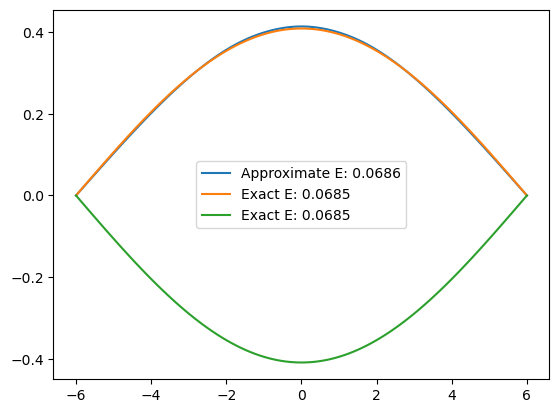

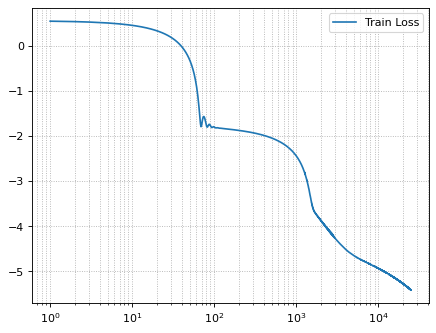

-------  1  -------


In [ ]:
pinn = ev_pinn(neurons_arr[0], xL, xR, grid_resol, batchsize, retrain_seed)

#training
history =pinn.learn_eigenfunction_set(4, epochs_arr, verbose=False)

plot_hist_not_log(history)

### Data analysis

In [ ]:
def compute_errors(NN, n): 
    # returns relative eigen value and function error
    pts = pinn.add_points()
    exact_func, exact_E = pinn.exact_solution(pts,n)
    aprox_func, approx_E = NN(pts)
    
    exact_func = exact_func.detach().numpy()
    aprox_func, approx_E = aprox_func.detach().numpy(), approx_E.detach().numpy()[0]
    
    MSE_1 = np.square((exact_func - aprox_func)).mean()
    MSE_2 = np.square((-exact_func - aprox_func)).mean()  #+- coeffcient 
    
    MSE = min(MSE_1, MSE_2) / max(abs(exact_func))  # relative to highest absolute value of exact sol
    
    error_E = abs((exact_E - approx_E) / exact_E)
    error_MSE = float(MSE)
    
    error_E_exp = "{:.2e}".format(float(error_E))
    error_MSE_exp = "{:.2e}".format(float(error_MSE))
    
    return error_E_exp, error_MSE_exp

In [ ]:
eigenvals = []

# get list of eigenvalues and sorted list arguments
for NN in pinn.eigenf_list:
    lambda_i = (NN.ev_in( torch.ones(1))).item() 
    eigenvals.append(lambda_i)
sort_arg = np.argsort(eigenvals)

print("##### Data analysis #####################")
print("_____ :  E error   : func error")
for n,i in enumerate(sort_arg):
    NN = pinn.eigenf_list[i]
    error_E, error_func = compute_errors(NN, n+1)
    print( f'n = {n} : ', error_E," : ", error_func)
print("#########################################")